# Correlation

- What is this notebook for? 
  - Analysing correlation among features with full join data

# 0. Preparation

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pyspark.sql.functions import desc

import geopandas as gpd
import folium

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.ml.classification import RandomForestClassifier
import time


In [0]:
!pip install dython

Collecting dython
 Downloading dython-0.7.1.post3-py3-none-any.whl (21 kB)
Collecting scikit-plot>=0.3.7
 Downloading scikit_plot-0.3.7-py3-none-any.whl (33 kB)
Collecting scipy>=1.7.1
 Downloading scipy-1.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 12.9 MB/s eta 0:00:00

Collecting numpy>=1.19.5
 Downloading numpy-1.22.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 34.0 MB/s eta 0:00:00

Collecting pandas>=1.3.2
 Downloading pandas-1.4.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 7.1 MB/s eta 0:00:00

Collecting scikit-learn>=0.24.2
 Downloading scikit_learn-1.0.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.3 MB/s eta 0:00:00

Collecting matplotlib>=3.4.3
 Downloading matplotlib-3.5.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 44.7 MB/s eta 0:00:00

Requirement already satisfied: seaborn>=0.11.0 in /databricks/python3/lib/python3.8/site-packages (from dython) (0.11.1)
Collecting fonttools>=4.22.0
 Downloading fonttools-4.32.0-py3-none-any.whl (900 kB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 900.8/900.8 KB 17.4 MB/s eta 0:00:00

Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=3.4.3->dython) (1.3.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=3.4.3->dython) (0.10.0)
Requirement already satisfied: pillow>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=3.4.3->dython) (8.2.0)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=3.4.3->dython) (2.4.7)
Requirement already satisfied: python-dateutil>=2.7 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=3.4.3->dython) (2.8.1)
Requirement already satisfied: packaging>=20.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=3.4.3->dython) (20.9)
Requirement already satisfied: pytz>=2020.1 in /databricks/python3/lib/python3.8/site-packages (from pandas>=1.3.2->dython) (2020.5)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.24.2->dython) (1.0.1)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.24.2->dython) (2.1.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib>=3.4.3->dython) (1.15.0)
Installing collected packages: numpy, fonttools, scipy, pandas, matplotlib, scikit-learn, scikit-plot, dython
 Attempting uninstall: numpy
 Found existing installation: numpy 1.19.2
 Uninstalling numpy-1.19.2:
 Successfully uninstalled numpy-1.19.2
 Attempting uninstall: scipy
 Found existing installation: scipy 1.6.2
 Uninstalling scipy-1.6.2:
 Successfully uninstalled scipy-1.6.2
 Attempting uninstall: pandas
 Found existing installation: pandas 1.2.4
 Uninstalling pandas-1.2.4:
 Successfully uninstalled pandas-1.2.4
 Attempting uninstall: matplotlib
 Found existing installation: matplotlib 3.4.2
 Uninstalling matplotlib-3.4.2:
 Successfully uninstalled matplotlib-3.4.2
 Attempting uninstall: scikit-learn
 Found existing installation: scikit-learn 0.24.1
 Uninstalling scikit-learn-0.24.1:
 Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.2 requires pyspark>=2.1.0, which is not installed.
tensorflow-c

In [0]:
from dython import nominal

--------------------------------------------------------------------------- 
 ContextualVersionConflict Traceback (most recent call last)
 <command-1858507102425568> in <module> 
 ----> 1 from dython import nominal

 /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch (name, globals, locals, fromlist, level) 
 160 # Import the desired module. If you’re seeing this while debugging a failed import, 
 161 # look at preceding stack frames for relevant error information. 
 --> 162 original_result = python_builtin_import ( name , globals , locals , fromlist , level ) 
 163 
 164 is_root_import = thread_local . _nest_level == 1 

 /databricks/python/lib/python3.8/site-packages/dython/__init__.py in <module> 
 10 
 11 __all__ = [ '__version__' ] 
 ---> 12 __version__ = _get_version_from_setuptools ( ) 

 /databricks/python/lib/python3.8/site-packages/dython/__init__.py in _get_version_from_setuptools () 
 6 def _get_version_from_setuptools ( ) : 
 7 from pkg_resources import get_distribution
 ----> 8 return get_distribution ( "dython" ) . version
 9 
 10 

 /usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py in get_distribution (dist) 
 464 dist = Requirement . parse ( dist ) 
 465 if isinstance ( dist , Requirement ) : 
 --> 466 dist = get_provider ( dist ) 
 467 if not isinstance ( dist , Distribution ) : 
 468 raise TypeError ( "Expected string, Requirement, or Distribution" , dist ) 

 /usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py in get_provider (moduleOrReq) 
 340 """Return an IResourceProvider for the named module or requirement""" 
 341 if isinstance ( moduleOrReq , Requirement ) : 
 --> 342 return working_set . find ( moduleOrReq ) or require ( str ( moduleOrReq ) ) [ 0 ] 
 343 try : 
 344 module = sys . modules [ moduleOrReq ] 

 /usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py in require (self, *requirements) 
 884 included , even if they were already activated in this working set . 
 885 """
 --> 886 needed = self . resolve ( parse_requirements ( requirements ) ) 
 887 
 888 for dist in needed : 

 /usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py in resolve (self, requirements, env, installer, replace_conflicting, extras) 
 775 # Oops, the "best" so far conflicts with a dependency 
 776 dependent_req = required_by [ req ] 
 --> 777 raise VersionConflict ( dist , req ) . with_context ( dependent_req ) 
 778 
 779 # push the new requirements onto the stack 

 ContextualVersionConflict : (matplotlib 3.4.2 (/databricks/python3/lib/python3.8/site-packages), Requirement.parse('matplotlib>=3.4.3'), {'dython'})

In [0]:
# Put at the top of any notebooks for storing in blob

from pyspark.sql.functions import col, max

blob_container = "team06" # The name of your container created in https://portal.azure.com
storage_account = "apatel" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team06" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team06" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

## Import full data(Including weather data)

In [0]:
df_5yr_join = spark.read.parquet(f'{blob_url}/full_join_mattsFeats_anandFeats_cleaned_extraFeatures_upToOD_good_v8_4-6-22')

In [0]:
display(df_5yr_join)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 CANCELLED ACTUAL_ELAPSED_TIME DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY LATE_AIRCRAFT_DELAY ORI_IATA ORI_station_id ORI_station_lat ORI_station_lon ORI_airport_lat ORI_airport_lon ORI_elevation ORI_dist_airp_sta DEST_IATA DEST_station_id DEST_station_lat DEST_station_lon DEST_airport_lat DEST_airport_lon DEST_elevation DEST_dist_airp_sta CRS_DEP_HRS CRS_DEP_MINS CRS_DEP_TIME_STR CRS_DEP_DT_STR CRS_DEP_DATETIME iata_code ORI_timezone CRS_DEP_DATETIME_UTC CRS_DEP_DATETIME_UTC_END CRS_DEP_DATETIME_UTC_START STATION DATE LATITUDE LONGITUDE ELEVATION REPORT_TYPE DEST_timezone DEP_HRS DEP_MINS DEP_TIME_STR DEP_DT_STR DEP_DATETIME ARR_DATETIME_ACTUAL_UTC late_night daytime evening region_name new_england mid_atlantic south midwest southwest west pacific_islands atlantic_islands spring summer autumn winter dep_date weekend_or_holiday flightID ID previous_flight_delay_status previous_flight_dep_time time_between_departures_min valid_dep_delay prior_dep_delayed previous_DEP_DELAY_NEW_value previous_DEP_DELAY_NEW previous_flight_arrdelay_status previous_flight_arr_time time_between_arrival_and_end_min valid_arr_delay prior_arr_delayed previous_ARR_DELAY_NEW_value previous_ARR_DELAY_NEW prev_arrival_airport plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs year_quarter quarter_enum quarter_enum_prev month_seq_index wnd_2_wind_obs_type wnd_3_wind_sp_rate cig_0_height vis_0_distance slp_0_day_avg tmp_0_air_temp dew_0_point_temp ma1_0_altimeter_setting_rate ma1_2_station_pressure_rate gd1_3_sky_cover_height WND_3_wind_speed CIG_0_sky_ceiling_height VIS_0_visibility_dist SLP_0_avg_station_press TMP_0_air_temperature DEW_0_dew_pt_temp MA1_0_altimeter_set_rate MA1_2_station_pres_rate OC1_0_wind_gust_spd_rate_imp GD1_3_cloud_height AA1_1_liquid_precip AA3_1_liquid_precip gd1_0_sky_coverage au2_4_extreme_wind_weather mv1_0_sand_dust_near mv1_0_thunder_rain_near aw1_mw1_0_smoke_haze_dust aw1_mw1_0_fog aw1_mw1_0_rain_drizzle aw1_mw1_0_freezing_rain_drizzle aw1_mw1_0_snow aw1_mw1_0_hail_or_ice aw1_mw1_0_thunderstorm aw1_mw1_0_tornado SLP_0_avg_station_press_imp WND_3_wind_speed_imp CIG_0_sky_ceiling_height_imp VIS_0_visibility_dist_imp TMP_0_air_temperature_imp DEW_0_dew_pt_temp_imp MA1_0_altimeter_set_rate_imp MA1_2_station_pres_rate_imp GD1_3_cloud_height_imp depDelayPageRank arrDelayPageRank UniqueID hour hour_UTC avg_hourly_delay_24hr OD_Pair avg_OD_dep_del15_24hr avg_OD_delay_min_24hr avg_OD_num_flights_24hr depDelayPageRank_ordinal arrDelayPageRank_ordinal recent_dep_time recent_dep_dest time_between_currentDepTime_recentDepTime dep_flight_after_prediction recent_dep_flight_coming_here departed_for_current_aiport 1st_most_recent_dep_UTC 2nd_most_recent_dep_UTC 1st_most_recent_arr_UTC 2nd_most_recent_arr_UTC 3rd_most_recent_arr_UTC col1_time_inb_flight_min col2_time_inb_flight_min col3_time_inb_flight_min time_inb_flight_min avg_time_inb_flights_carrier_24hr avg_time_inb_flights_origin_24hr avg_time_inb_flights_dest_24hr avg_ori_DEP_DELAY_NEW_24hr airline_carrier_del airline_carrier_del_min avg_carrier_delay_over15_lastQ airline_carrier_del_ordinal airline_carrier_del_min_ordinal origin_avg_DEP_DEL15 origin_avg_DEP_DELAY_NEW avg_origin_delay_over15_lastQ origin_del_ordinal origin_del_min_ordinal OD_avg_DEP_DEL15 OD_avg_DEP_DELAY_NEW avg_OD_delay_over15_lastQ OD_del_ordinal OD_del_min_ordinal 2018 1 1 1 1 2018-01-01 9E 20363 N295PQ 4125 11193 1119302 CVG KY 21 Kentucky 12478 1247805 JFK NY 36 New York 1524 1655 91.0 91.0 1.0 6 

In [0]:
df_5yr_join.columns

Out[7]: ['YEAR',
 'QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'TAIL_NUM',
 'OP_CARRIER_FL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID',
 'ORIGIN',
 'ORIGIN_STATE_ABR',
 'ORIGIN_STATE_FIPS',
 'ORIGIN_STATE_NM',
 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID',
 'DEST',
 'DEST_STATE_ABR',
 'DEST_STATE_FIPS',
 'DEST_STATE_NM',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'CANCELLED',
 'ACTUAL_ELAPSED_TIME',
 'DISTANCE',
 'DISTANCE_GROUP',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'ORI_IATA',
 'ORI_station_id',
 'ORI_station_lat',
 'ORI_station_lon',
 'ORI_airport_lat',
 'ORI_airport_lon',
 'ORI_elevation',
 'ORI_dist_airp_sta',
 'DEST_IATA',
 'DEST_station_id',
 'DEST_station_lat',
 'DEST_station_lon',
 'DEST_airport_lat',
 'DEST_airport_lon',
 'DEST_elevation',
 'DEST_dist_airp_sta',
 'CRS_DEP_HRS',
 'CRS_DEP_MINS',
 'CRS_DEP_TIME_STR',
 'CRS_DEP_DT_STR',
 'CRS_DEP_DATETIME',
 'iata_code',
 'ORI_timezone',
 'CRS_DEP_DATETIME_UTC',
 'CRS_DEP_DATETIME_UTC_END',
 'CRS_DEP_DATETIME_UTC_START',
 'STATION',
 'DATE',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'REPORT_TYPE',
 'DEST_timezone',
 'DEP_HRS',
 'DEP_MINS',
 'DEP_TIME_STR',
 'DEP_DT_STR',
 'DEP_DATETIME',
 'ARR_DATETIME_ACTUAL_UTC',
 'late_night',
 'daytime',
 'evening',
 'region_name',
 'new_england',
 'mid_atlantic',
 'south',
 'midwest',
 'southwest',
 'west',
 'pacific_islands',
 'atlantic_islands',
 'spring',
 'summer',
 'autumn',
 'winter',
 'dep_date',
 'weekend_or_holiday',
 'flightID',
 'ID',
 'previous_flight_delay_status',
 'previous_flight_dep_time',
 'time_between_departures_min',
 'valid_dep_delay',
 'prior_dep_delayed',
 'previous_DEP_DELAY_NEW_value',
 'previous_DEP_DELAY_NEW',
 'previous_flight_arrdelay_status',
 'previous_flight_arr_time',
 'time_between_arrival_and_end_min',
 'valid_arr_delay',
 'prior_arr_delayed',
 'previous_ARR_DELAY_NEW_value',
 'previous_ARR_DELAY_NEW',
 'prev_arrival_airport',
 'plane_is_here',
 'avg_carrier_delay_24hrs',
 'flights_sch_Today_ORIGIN',
 'flights_sch_Today_DEST',
 'avg_ori_airport_delay_24hrs',
 'year_quarter',
 'quarter_enum',
 'quarter_enum_prev',
 'month_seq_index',
 'wnd_2_wind_obs_type',
 'wnd_3_wind_sp_rate',
 'cig_0_height',
 'vis_0_distance',
 'slp_0_day_avg',
 'tmp_0_air_temp',
 'dew_0_point_temp',
 'ma1_0_altimeter_setting_rate',
 'ma1_2_station_pressure_rate',
 'gd1_3_sky_cover_height',
 'WND_3_wind_speed',
 'CIG_0_sky_ceiling_height',
 'VIS_0_visibility_dist',
 'SLP_0_avg_station_press',
 'TMP_0_air_temperature',
 'DEW_0_dew_pt_temp',
 'MA1_0_altimeter_set_rate',
 'MA1_2_station_pres_rate',
 'OC1_0_wind_gust_spd_rate_imp',
 'GD1_3_cloud_height',
 'AA1_1_liquid_precip',
 'AA3_1_liquid_precip',
 'gd1_0_sky_coverage',
 'au2_4_extreme_wind_weather',
 'mv1_0_sand_dust_near',
 'mv1_0_thunder_rain_near',
 'aw1_mw1_0_smoke_haze_dust',
 'aw1_mw1_0_fog',
 'aw1_mw1_0_rain_drizzle',
 'aw1_mw1_0_freezing_rain_drizzle',
 'aw1_mw1_0_snow',
 'aw1_mw1_0_hail_or_ice',
 'aw1_mw1_0_thunderstorm',
 'aw1_mw1_0_tornado',
 'SLP_0_avg_station_press_imp',
 'WND_3_wind_speed_imp',
 'CIG_0_sky_ceiling_height_imp',
 'VIS_0_visibility_dist_imp',
 'TMP_0_air_temperature_imp',
 'DEW_0_dew_pt_temp_imp',
 'MA1_0_altimeter_set_rate_imp',
 'MA1_2_station_pres_rate_imp',
 'GD1_3_cloud_height_imp',
 'depDelayPageRank',
 'arrDelayPageRank',
 'UniqueID',
 'hour',
 'hour_UTC',
 'avg_hourly_delay_24hr',
 'OD_Pair',
 'avg_OD_dep_del15_24hr',
 'avg_OD_delay_min_24hr',
 'avg_OD_num_flights_24hr',
 'depDelayPageRank_ordinal',
 'arrDelayPageRank_ordinal',
 'recent_dep_time',
 'recent_dep_dest',
 'time_between_currentDepTime_recentDepTime',
 'dep_flight_after_prediction',
 'recent_dep_flight_coming_here',
 'departed_for_current_aiport',
 '1st_most_recent_dep_UTC',
 '2nd_most_recent_dep_UTC',
 '1st_most_recent_ar

In [0]:
# copied from section `Flights Features to Keep`
Features_for_flights=[ 'DISTANCE','ORI_elevation','DEST_elevation', 
                   'prior_dep_delayed', 'previous_DEP_DELAY_NEW',
                    'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here',
                    'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs',
                    'late_night', 'daytime', 'evening',
                    'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands',
                    'spring', 'summer', 'winter', 'autumn',
                    'weekend_or_holiday'
                   ]

# Features_for_weathers=['WND_3_wind_speed','CIG_0_sky_ceiling_height','VIS_0_visibility_dist','SLP_0_avg_station_press',
#                        'TMP_0_air_temperature','DEW_0_dew_pt_temp','MA1_0_altimeter_set_rate','MA1_2_station_pres_rate',
#                        'OC1_0_wind_gust_spd_rate_imp','GD1_3_cloud_height','AA1_1_liquid_precip','AA3_1_liquid_precip','gd1_0_sky_coverage',
#                        'au2_4_extreme_wind_weather','mv1_0_sand_dust_near','mv1_0_thunder_rain_near','aw1_mw1_0_smoke_haze_dust','aw1_mw1_0_fog',
#                        'aw1_mw1_0_rain_drizzle','aw1_mw1_0_freezing_rain_drizzle','aw1_mw1_0_snow','aw1_mw1_0_hail_or_ice','aw1_mw1_0_thunderstorm',
#                        'aw1_mw1_0_tornado','SLP_0_avg_station_press_imp','WND_3_wind_speed_imp','CIG_0_sky_ceiling_height_imp',
#                        'VIS_0_visibility_dist_imp','TMP_0_air_temperature_imp','DEW_0_dew_pt_temp_imp','MA1_0_altimeter_set_rate_imp',
#                        'MA1_2_station_pres_rate_imp','GD1_3_cloud_height_imp']

Features_for_weathers = ['OC1_0_wind_gust_spd_rate_imp', 'AA1_1_liquid_precip', 'AA3_1_liquid_precip', 'SLP_0_avg_station_press_imp', 'WND_3_wind_speed_imp', 'CIG_0_sky_ceiling_height_imp', 'VIS_0_visibility_dist_imp', 'TMP_0_air_temperature_imp', 'DEW_0_dew_pt_temp_imp', 'MA1_0_altimeter_set_rate_imp', 'MA1_2_station_pres_rate_imp', 'GD1_3_cloud_height_imp', 'gd1_0_sky_coverage', 'au2_4_extreme_wind_weather', 'mv1_0_sand_dust_near', 'mv1_0_thunder_rain_near', 'aw1_mw1_0_smoke_haze_dust', 'aw1_mw1_0_fog', 'aw1_mw1_0_rain_drizzle', 'aw1_mw1_0_freezing_rain_drizzle', 'aw1_mw1_0_snow', 'aw1_mw1_0_hail_or_ice', 'aw1_mw1_0_thunderstorm', 'aw1_mw1_0_tornado']



# specify any outcome variables you also want to check for missing
Outcomes_for_flights=[ 'DEP_DEL15', 'DEP_DELAY_NEW']

# combine:
cols_to_check = Outcomes_for_flights + Features_for_flights + Features_for_weathers

print(cols_to_check)

['DEP_DEL15', 'DEP_DELAY_NEW', 'DISTANCE', 'ORI_elevation', 'DEST_elevation', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here', 'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs', 'late_night', 'daytime', 'evening', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'atlantic_islands', 'spring', 'summer', 'winter', 'autumn', 'weekend_or_holiday', 'OC1_0_wind_gust_spd_rate_imp', 'AA1_1_liquid_precip', 'AA3_1_liquid_precip', 'SLP_0_avg_station_press_imp', 'WND_3_wind_speed_imp', 'CIG_0_sky_ceiling_height_imp', 'VIS_0_visibility_dist_imp', 'TMP_0_air_temperature_imp', 'DEW_0_dew_pt_temp_imp', 'MA1_0_altimeter_set_rate_imp', 'MA1_2_station_pres_rate_imp', 'GD1_3_cloud_height_imp', 'gd1_0_sky_coverage', 'au2_4_extreme_wind_weather', 'mv1_0_sand_dust_near', 'mv1_0_thunder_rain_near', 'aw1_mw1_0_smoke_haze_dust', 'aw1_mw1_0_fog', 'aw1_mw1_0_rain_drizzle', 'aw1_mw1_0_freezing_rain_drizzle', 'aw1_mw1_0_snow', 'aw1_mw1_0_hail_or_ice', 'aw1_mw1_0_thunderstorm', 'aw1_mw1_0_tornado']

In [0]:
feature_list_full = ['DISTANCE', 'ORI_elevation', 'DEST_elevation', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'prior_arr_delayed', 'previous_ARR_DELAY_NEW', 'plane_is_here', 'avg_carrier_delay_24hrs', 'flights_sch_Today_ORIGIN', 'flights_sch_Today_DEST', 'avg_ori_airport_delay_24hrs', 'daytime', 'evening', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'pacific_islands', 'spring', 'winter', 'autumn', 'weekend_or_holiday', 'prior_dep_delayed', 'previous_DEP_DELAY_NEW', 'plane_is_here', 'previous_ARR_DELAY_NEW', 'avg_carrier_delay_24hrs', 'prior_arr_delayed', 'avg_ori_airport_delay_24hrs', 'depDelayPageRank', 'arrDelayPageRank', 'OC1_0_wind_gust_spd_rate_imp', 'AA1_1_liquid_precip', 'AA3_1_liquid_precip', 'gd1_0_sky_coverage', 'au2_4_extreme_wind_weather', 'mv1_0_sand_dust_near', 'mv1_0_thunder_rain_near', 'aw1_mw1_0_smoke_haze_dust', 'aw1_mw1_0_fog', 'aw1_mw1_0_rain_drizzle', 'aw1_mw1_0_freezing_rain_drizzle', 'aw1_mw1_0_snow', 'aw1_mw1_0_hail_or_ice', 'aw1_mw1_0_thunderstorm', 'aw1_mw1_0_tornado', 'SLP_0_avg_station_press_imp', 'WND_3_wind_speed_imp', 'CIG_0_sky_ceiling_height_imp', 'VIS_0_visibility_dist_imp', 'TMP_0_air_temperature_imp', 'DEW_0_dew_pt_temp_imp', 'MA1_0_altimeter_set_rate_imp', 'MA1_2_station_pres_rate_imp', 'GD1_3_cloud_height_imp', 'avg_hourly_delay_24hr', 'avg_OD_dep_del15_24hr', 'avg_OD_delay_min_24hr', 'avg_OD_num_flights_24hr', 'depDelayPageRank_ordinal', 'arrDelayPageRank_ordinal', 'departed_for_current_aiport', 'time_inb_flight_min', 'avg_time_inb_flights_carrier_24hr', 'avg_time_inb_flights_origin_24hr', 'avg_time_inb_flights_dest_24hr', 'avg_ori_DEP_DELAY_NEW_24hr', 'airline_carrier_del', 'airline_carrier_del_min', 'avg_carrier_delay_over15_lastQ', 'airline_carrier_del_ordinal', 'airline_carrier_del_min_ordinal', 'origin_avg_DEP_DEL15', 'origin_avg_DEP_DELAY_NEW', 'avg_origin_delay_over15_lastQ', 'origin_del_ordinal', 'origin_del_min_ordinal', 'OD_avg_DEP_DEL15', 'OD_avg_DEP_DELAY_NEW', 'avg_OD_delay_over15_lastQ', 'OD_del_ordinal', 'OD_del_min_ordinal']

In [0]:
print(len(feature_list_full))

85

In [0]:
feature_list_t1 = ['previous_DEP_DELAY_NEW',
'prior_dep_delayed',
'time_inb_flight_min',
'avg_hourly_delay_24hr',
'plane_is_here',
'evening',
'avg_OD_dep_del15_24hr',
'previous_ARR_DELAY_NEW',
'avg_ori_airport_delay_24hrs',
'avg_carrier_delay_24hrs',
'prior_arr_delayed',
'daytime',
'avg_ori_DEP_DELAY_NEW_24hr',
'OD_avg_DEP_DEL15']

print(f"Feature List T1: {feature_list_t1}\n")

feature_list_t2 = [
  'departed_for_current_aiport',
'OD_del_ordinal',
'avg_OD_delay_min_24hr',
'TMP_0_air_temperature_imp',
'WND_3_wind_speed_imp',
'avg_OD_delay_over15_lastQ',
'airline_carrier_del_min',
'airline_carrier_del',
'aw1_mw1_0_thunderstorm',
'OD_del_min_ordinal',
'airline_carrier_del_ordinal',
'VIS_0_visibility_dist_imp',
'depDelayPageRank_ordinal',
'aw1_mw1_0_rain_drizzle',
'DISTANCE',
'origin_avg_DEP_DEL15',
'arrDelayPageRank_ordinal',
'airline_carrier_del_min_ordinal',
'CIG_0_sky_ceiling_height_imp',
'pacific_islands',
'flights_sch_Today_DEST',
'avg_time_inb_flights_carrier_24hr',
'origin_avg_DEP_DELAY_NEW',
'flights_sch_Today_ORIGIN',
'DEW_0_dew_pt_temp_imp',
'aw1_mw1_0_snow',
]

print(f"Feature List T2: {feature_list_t2}\n")

Feature List T1: ['previous_DEP_DELAY_NEW', 'prior_dep_delayed', 'time_inb_flight_min', 'avg_hourly_delay_24hr', 'plane_is_here', 'evening', 'avg_OD_dep_del15_24hr', 'previous_ARR_DELAY_NEW', 'avg_ori_airport_delay_24hrs', 'avg_carrier_delay_24hrs', 'prior_arr_delayed', 'daytime', 'avg_ori_DEP_DELAY_NEW_24hr', 'OD_avg_DEP_DEL15']

Feature List T2: ['departed_for_current_aiport', 'OD_del_ordinal', 'avg_OD_delay_min_24hr', 'TMP_0_air_temperature_imp', 'WND_3_wind_speed_imp', 'avg_OD_delay_over15_lastQ', 'airline_carrier_del_min', 'airline_carrier_del', 'aw1_mw1_0_thunderstorm', 'OD_del_min_ordinal', 'airline_carrier_del_ordinal', 'VIS_0_visibility_dist_imp', 'depDelayPageRank_ordinal', 'aw1_mw1_0_rain_drizzle', 'DISTANCE', 'origin_avg_DEP_DEL15', 'arrDelayPageRank_ordinal', 'airline_carrier_del_min_ordinal', 'CIG_0_sky_ceiling_height_imp', 'pacific_islands', 'flights_sch_Today_DEST', 'avg_time_inb_flights_carrier_24hr', 'origin_avg_DEP_DELAY_NEW', 'flights_sch_Today_ORIGIN', 'DEW_0_dew_pt_temp_imp', 'aw1_mw1_0_snow']

In [0]:
features_for_corr =  ['DEP_DEL15'] + Features_for_flights + Features_for_weathers

In [0]:
features_for_corr_full = ['DEP_DEL15'] + feature_list_full
print(len(features_for_corr_full))

86

## Select features for CV split and modeling

In [0]:
# df_5yr_join_corr = df_5yr_join.select(features_for_corr)
# df_5yr_join_corr = df_5yr_join.where((col('YEAR').cast('int') != 2019)).cache() # If looking at training data only since 2019 is test
# df_5yr_join_corr = df_5yr_join_corr.select(features_for_corr_full)

df_5yr_join_corr = df_5yr_join.select(features_for_corr_full)


In [0]:
display(df_5yr_join_corr)

DEP_DEL15 DISTANCE ORI_elevation DEST_elevation prior_dep_delayed previous_DEP_DELAY_NEW prior_arr_delayed previous_ARR_DELAY_NEW plane_is_here avg_carrier_delay_24hrs flights_sch_Today_ORIGIN flights_sch_Today_DEST avg_ori_airport_delay_24hrs daytime evening new_england mid_atlantic south midwest southwest west pacific_islands spring winter autumn weekend_or_holiday prior_dep_delayed previous_DEP_DELAY_NEW plane_is_here previous_ARR_DELAY_NEW avg_carrier_delay_24hrs prior_arr_delayed avg_ori_airport_delay_24hrs depDelayPageRank arrDelayPageRank OC1_0_wind_gust_spd_rate_imp AA1_1_liquid_precip AA3_1_liquid_precip gd1_0_sky_coverage au2_4_extreme_wind_weather mv1_0_sand_dust_near mv1_0_thunder_rain_near aw1_mw1_0_smoke_haze_dust aw1_mw1_0_fog aw1_mw1_0_rain_drizzle aw1_mw1_0_freezing_rain_drizzle aw1_mw1_0_snow aw1_mw1_0_hail_or_ice aw1_mw1_0_thunderstorm aw1_mw1_0_tornado SLP_0_avg_station_press_imp WND_3_wind_speed_imp CIG_0_sky_ceiling_height_imp VIS_0_visibility_dist_imp TMP_0_air_temperature_imp DEW_0_dew_pt_temp_imp MA1_0_altimeter_set_rate_imp MA1_2_station_pres_rate_imp GD1_3_cloud_height_imp avg_hourly_delay_24hr avg_OD_dep_del15_24hr avg_OD_delay_min_24hr avg_OD_num_flights_24hr depDelayPageRank_ordinal arrDelayPageRank_ordinal departed_for_current_aiport time_inb_flight_min avg_time_inb_flights_carrier_24hr avg_time_inb_flights_origin_24hr avg_time_inb_flights_dest_24hr avg_ori_DEP_DELAY_NEW_24hr airline_carrier_del airline_carrier_del_min avg_carrier_delay_over15_lastQ airline_carrier_del_ordinal airline_carrier_del_min_ordinal origin_avg_DEP_DEL15 origin_avg_DEP_DELAY_NEW avg_origin_delay_over15_lastQ origin_del_ordinal origin_del_min_ordinal OD_avg_DEP_DEL15 OD_avg_DEP_DELAY_NEW avg_OD_delay_over15_lastQ OD_del_ordinal OD_del_min_ordinal 1.0 2327.0 60.0 9.0 0 0.0 0 0.0 0 0.52 27 202 0.15 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0.0 0 0.0 0.52 0 0.15 0.003500544675913835 0.0027747531201398517 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10163.0 31.0 11524.85510428101 16000.0 211.0 144.0 10135.871569703622 10150.0 449.78504672897196 0.241 0.15 9.029411764705882 0 66 82 0 64.0 431.78 212.18 330.3 9.029411764705882 0.2174832779656472 14.362938906848212 0 3 2 0.15740380878352117 9.674698795180722 0 78 166 1.0 356.0 1 1 1 0.0 1265.0 6451.0 97.0 1 60.0 1 56.0 1 0.18 18 291 0.05 1 0 0 0 0 0 0 1 0 0 0 0 1 1 60.0 1 56.0 0.18 1 0.05 0.0026349144472628 0.0025650351982225914 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10164.16002896452 0.0 22000.0 16093.0 110.0 30.0 10213.0 8050.0 3658.0 0.084 0.05 4.35 0 81 87 1 610.0 498.03 406.35 481.47 4.35 0.1799934090296294 13.464977980167172 0 6 4 0.11722141823444283 10.40520984081042 0 168 141 0.3333333333333333 138.66666666666666 1 81 2 0.0 1265.0 6451.0 97.0 0 0.0 0 0.0 1 0.1 18 391 0.29 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0.0 1 0.0 0.1 0 0.29 0.0026349144472628 0.0025650351982225914 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10164.16002896452 0.0 22000.0 16093.0 110.0 30.0 10186.0 8027.0 2896.0 0.078 0.29 27.142857142857142 0 81 87 1 681.0 696.44 701.07 697.89 27.142857142857142 0.1799934090296294 13.464977980167172 0 6 4 0.11722141823444283 10.40520984081042 0 168 141 0.3333333333333333 138.66666666666666 1 81 2 0.0 1265.0 6451.0 97.0 0 0.0 0 0.0 1 0.17 18 392 0.11 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0.0 1 0.0 0.17 0 0.11 0.0026349144472628 0.0025650351982225914 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10164.16002896452 15.0 3353.0 16093.0 80.0 30.0 10173.0 8016.0 2591.0 0.11 0.0 0.0 1 81 87 1 681.0 978.39 396.39 438.94 4.833333333333333 0.1799934090296294 13.464977980167172 0 6 4 0.11722141823444283 10.40520984081042 0 168 141 0.3333333333333333 138.66666666666666 1 81 2 0.0 1265.0 6451.0 97.0 0 1.0 0 0.0 1 0.22 17 391 0.22 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1.0 1 0.0 0.22 0 0.22 0.0026349144472628 0.0025650351982225914 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10164.16002896452 26.0 22000.0 16093.0 20.0 -10.0 10196.0 8036.0 2521.8595317725753 0.134 0.0 0.0 1 81 87 1 669.0 702.24 516.11 820.54 6.444444444444445 0.1799934090296294 13.464977980167172 0 6 4 0.11722141823444283 10.40

In [0]:
print(f"Number of rows in dataset post-join: {df_5yr_join_corr.count()}")

Number of rows in dataset pre-split: 31080934

## Pearson Correlation (EDA)

In [0]:
features_for_corr

Out[17]: ['DEP_DEL15',
 'DISTANCE',
 'ORI_elevation',
 'DEST_elevation',
 'prior_dep_delayed',
 'previous_DEP_DELAY_NEW',
 'prior_arr_delayed',
 'previous_ARR_DELAY_NEW',
 'plane_is_here',
 'avg_carrier_delay_24hrs',
 'flights_sch_Today_ORIGIN',
 'flights_sch_Today_DEST',
 'avg_ori_airport_delay_24hrs',
 'late_night',
 'daytime',
 'evening',
 'new_england',
 'mid_atlantic',
 'south',
 'midwest',
 'southwest',
 'west',
 'pacific_islands',
 'atlantic_islands',
 'spring',
 'summer',
 'winter',
 'autumn',
 'weekend_or_holiday',
 'OC1_0_wind_gust_spd_rate_imp',
 'AA1_1_liquid_precip',
 'AA3_1_liquid_precip',
 'SLP_0_avg_station_press_imp',
 'WND_3_wind_speed_imp',
 'CIG_0_sky_ceiling_height_imp',
 'VIS_0_visibility_dist_imp',
 'TMP_0_air_temperature_imp',
 'DEW_0_dew_pt_temp_imp',
 'MA1_0_altimeter_set_rate_imp',
 'MA1_2_station_pres_rate_imp',
 'GD1_3_cloud_height_imp',
 'gd1_0_sky_coverage',
 'au2_4_extreme_wind_weather',
 'mv1_0_sand_dust_near',
 'mv1_0_thunder_rain_near',
 'aw1_mw1_0_smoke_haze_dust',
 'aw1_mw1_0_fog',
 'aw1_mw1_0_rain_drizzle',
 'aw1_mw1_0_freezing_rain_drizzle',
 'aw1_mw1_0_snow',
 'aw1_mw1_0_hail_or_ice',
 'aw1_mw1_0_thunderstorm',
 'aw1_mw1_0_tornado']

In [0]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col


In [0]:
#change column name
from pyspark.sql.functions import col

df_5yr_join_short_name = df_5yr_join_corr.select(col('OC1_0_wind_gust_spd_rate_imp').alias('OC1_0_wind_gust_spd_rate'), col('WND_3_wind_speed_imp').alias('WND_3_wind_speed'),
                                                 col('TMP_0_air_temperature_imp').alias('TMP_0_air_temperature'), col('DEW_0_dew_pt_temp_imp').alias('DEW_0_dew_pt_temp'),
                                                 col('MA1_0_altimeter_set_rate_imp').alias('MA1_0_altimeter_set_rate'),col('MA1_2_station_pres_rate_imp').alias('MA1_2_station_pres_rate'))

corr_list =  ['OC1_0_wind_gust_spd_rate',  'WND_3_wind_speed','TMP_0_air_temperature', 'DEW_0_dew_pt_temp','MA1_0_altimeter_set_rate', 'MA1_2_station_pres_rate'] + ['DEP_DEL15']
# 'DEP_DEL15',
#'AA1_1_liquid_precip', 'AA3_1_liquid_precip','CIG_0_sky_ceiling_height_imp', 'VIS_0_visibility_dist_imp','GD1_3_cloud_height_imp','SLP_0_avg_station_press_imp'


In [0]:
corr_WND_df = df_5yr_join_short_name.select(corr_list)

col_names = corr_WND_df.columns
features = corr_WND_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-1858507102425489> in <module> 
 ----> 1 corr_WND_df = df_5yr_join_short_name . select ( corr_list ) 
 2 
 3 col_names = corr_WND_df . columns
 4 features = corr_WND_df . rdd . map ( lambda row : row [ 0 : ] ) 
 5 corr_mat = Statistics . corr ( features , method = 'pearson' ) 

 /databricks/spark/python/pyspark/sql/dataframe.py in select (self, *cols) 
 1690 [ Row ( name = 'Alice' , age = 12 ) , Row ( name = 'Bob' , age = 15 ) ] 
 1691 """
 -> 1692 jdf = self . _jdf . select ( self . _jcols ( * cols ) ) 
 1693 return DataFrame ( jdf , self . sql_ctx ) 
 1694 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : cannot resolve '`DEP_DEL15`' given input columns: [DEW_0_dew_pt_temp, MA1_0_altimeter_set_rate, MA1_2_station_pres_rate, OC1_0_wind_gust_spd_rate, TMP_0_air_temperature, WND_3_wind_speed];
'Project [OC1_0_wind_gust_spd_rate#961716, WND_3_wind_speed#961717, TMP_0_air_temperature#961718, DEW_0_dew_pt_temp#961719, MA1_0_altimeter_set_rate#961720, MA1_2_station_pres_rate#961721, 'DEP_DEL15]
+- Project [OC1_0_wind_gust_spd_rate_imp#959564 AS OC1_0_wind_gust_spd_rate#961716, WND_3_wind_speed_imp#959581 AS WND_3_wind_speed#961717, TMP_0_air_temperature_imp#959584 AS TMP_0_air_temperature#961718, DEW_0_dew_pt_temp_imp#959585 AS DEW_0_dew_pt_temp#961719, MA1_0_altimeter_set_rate_imp#959586 AS MA1_0_altimeter_set_rate#961720, MA1_2_station_pres_rate_imp#959587 AS MA1_2_station_pres_rate#961721]
 +- Project [DEP_DEL15#959447, DISTANCE#959457, ORI_elevation#959469, DEST_elevation#959477, prior_dep_delayed#959526, previous_DEP_DELAY_NEW#959528, prior_arr_delayed#959533, previous_ARR_DELAY_NEW#959535, plane_is_here#959537, avg_carrier_delay_24hrs#959538, flights_sch_Today_ORIGIN#959539L, flights_sch_Today_DEST#959540L, avg_ori_airport_delay_24hrs#959541, daytime#959503, evening#959504, new_england#959506, mid_atlantic#959507, south#959508, midwest#959509, southwest#959510, west#959511, pacific_islands#959512, spring#959514, winter#959517, ... 62 more fields]
 +- Relation[YEAR#959421,QUARTER#959422,MONTH#959423,DAY_OF_MONTH#959424,DAY_OF_WEEK#959425,FL_DATE#959426,OP_UNIQUE_CARRIER#959427,OP_CARRIER_AIRLINE_ID#959428,TAIL_NUM#959429,OP_CARRIER_FL_NUM#959430,ORIGIN_AIRPORT_ID#959431,ORIGIN_AIRPORT_SEQ_ID#959432,ORIGIN#959433,ORIGIN_STATE_ABR#959434,ORIGIN_STATE_FIPS#959435,ORIGIN_STATE_NM#959436,DEST_AIRPORT_ID#959437,DEST_AIRPORT_SEQ_ID#959438,DEST#959439,DEST_STATE_ABR#959440,DEST_STATE_FIPS#959441,DEST_STATE_NM#959442,CRS_DEP_TIME#959443,DEP_TIME#959444,... 190 more fields] parquet

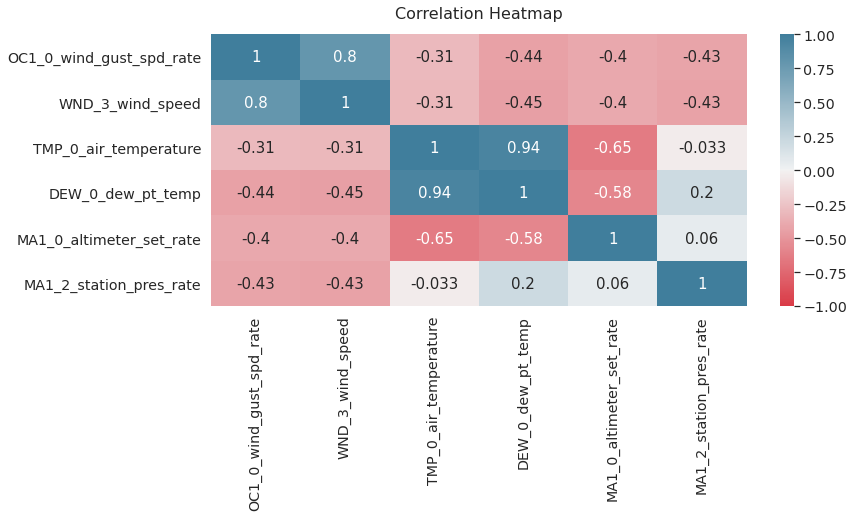

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(12, 5))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')


##Plotting Correlation Tables

In [0]:
print(feature_list_t1)

['previous_DEP_DELAY_NEW', 'prior_dep_delayed', 'time_inb_flight_min', 'avg_hourly_delay_24hr', 'plane_is_here', 'evening', 'avg_OD_dep_del15_24hr', 'previous_ARR_DELAY_NEW', 'avg_ori_airport_delay_24hrs', 'avg_carrier_delay_24hrs', 'prior_arr_delayed', 'daytime', 'avg_ori_DEP_DELAY_NEW_24hr', 'OD_avg_DEP_DEL15']

In [0]:
corr_t1_df = df_5yr_join_corr.select(feature_list_t1 + ['DEP_DEL15'])

col_names = corr_t1_df.columns
features = corr_t1_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

Out[26]:

previous_DEP_DELAY_NEW 
 prior_dep_delayed 
 time_inb_flight_min 
 avg_hourly_delay_24hr 
 plane_is_here 
 evening 
 avg_OD_dep_del15_24hr 
 previous_ARR_DELAY_NEW 
 avg_ori_airport_delay_24hrs 
 avg_carrier_delay_24hrs 
 prior_arr_delayed 
 daytime 
 avg_ori_DEP_DELAY_NEW_24hr 
 OD_avg_DEP_DEL15 
 DEP_DEL15 
 
 
 
 
 previous_DEP_DELAY_NEW 
 1.000000 
 0.614631 
 0.006398 
 0.042253 
 0.064233 
 0.000794 
 0.107567 
 0.480366 
 0.148403 
 0.166361 
 0.362191 
 -0.020119 
 0.145881 
 0.041251 
 0.239399 
 
 
 prior_dep_delayed 
 0.614631 
 1.000000 
 0.001244 
 0.061018 
 0.097124 
 0.015337 
 0.121586 
 0.309406 
 0.166546 
 0.204390 
 0.441418 
 -0.044864 
 0.137752 
 0.055728 
 0.299178 
 
 
 time_inb_flight_min 
 0.006398 
 0.001244 
 1.000000 
 -0.028377 
 0.034616 
 -0.042880 
 0.000804 
 0.007667 
 0.001118 
 -0.002178 
 0.013217 
 0.042773 
 0.002052 
 0.000875 
 0.000670 
 
 
 avg_hourly_delay_24hr 
 0.042253 
 0.061018 
 -0.028377 
 1.000000 
 -0.356251 
 0.543307 
 0.210761 
 -0.088249 
 0.357921 
 0.433344 
 -0.144061 
 -0.512191 
 0.261762 
 0.056735 
 0.207232 
 
 
 plane_is_here 
 0.064233 
 0.097124 
 0.034616 
 -0.356251 
 1.000000 
 -0.319881 
 -0.035630 
 0.235327 
 -0.028968 
 -0.036147 
 0.376775 
 0.249952 
 -0.010727 
 -0.070197 
 -0.130656 
 
 
 evening 
 0.000794 
 0.015337 
 -0.042880 
 0.543307 
 -0.319881 
 1.000000 
 0.022189 
 -0.105299 
 0.009520 
 0.007711 
 -0.158079 
 -0.888057 
 0.000732 
 0.055707 
 0.143902 
 
 
 avg_OD_dep_del15_24hr 
 0.107567 
 0.121586 
 0.000804 
 0.210761 
 -0.035630 
 0.022189 
 1.000000 
 0.067039 
 0.526095 
 0.360632 
 0.071424 
 -0.020766 
 0.413604 
 0.194924 
 0.157434 
 
 
 previous_ARR_DELAY_NEW 
 0.480366 
 0.309406 
 0.007667 
 -0.088249 
 0.235327 
 -0.105299 
 0.067039 
 1.000000 
 0.098996 
 0.108172 
 0.652252 
 0.086399 
 0.104393 
 0.009551 
 0.004434 
 
 
 avg_ori_airport_delay_24hrs 
 0.148403 
 0.166546 
 0.001118 
 0.357921 
 -0.028968 
 0.009520 
 0.526095 
 0.098996 
 1.000000 
 0.552584 
 0.110331 
 -0.010309 
 0.789267 
 0.154794 
 0.184930 
 
 
 avg_carrier_delay_24hrs 
 0.166361 
 0.204390 
 -0.002178 
 0.433344 
 -0.036147 
 0.007711 
 0.360632 
 0.108172 
 0.552584 
 1.000000 
 0.125097 
 -0.016535 
 0.423129 
 0.130424 
 0.189663 
 
 
 prior_arr_delayed 
 0.362191 
 0.441418 
 0.013217 
 -0.144061 
 0.376775 
 -0.158079 
 0.071424 
 0.652252 
 0.110331 
 0.125097 
 1.000000 
 0.126142 
 0.101634 
 0.004216 
 -0.017769 
 
 
 daytime 
 -0.020119 
 -0.044864 
 0.042773 
 -0.512191 
 0.249952 
 -0.888057 
 -0.020766 
 0.086399 
 -0.010309 
 -0.016535 
 0.126142 
 1.000000 
 0.000193 
 -0.042784 
 -0.136060 
 
 
 avg_ori_DEP_DELAY_NEW_24hr 
 0.145881 
 0.137752 
 0.002052 
 0.261762 
 -0.010727 
 0.000732 
 0.413604 
 0.104393 
 0.789267 
 0.423129 
 0.101634 
 0.000193 
 1.000000 
 0.080595 
 0.148936 
 
 
 OD_avg_DEP_DEL15 
 0.041251 
 0.055728 
 0.000875 
 0.056735 
 -0.070197 
 0.055707 
 0.194924 
 0.009551 
 0.154794 
 0.130424 
 0.004216 
 -0.042784 
 0.080595 
 1.000000 
 0.109782 
 
 
 DEP_DEL15 
 0.239399 
 0.299178 
 0.000670 
 0.207232 
 -0.130656 
 0.143902 
 0.157434 
 0.004434 
 0.184930 
 0.189663 
 -0.017769 
 -0.136060 
 0.148936 
 0.109782 
 1.000000

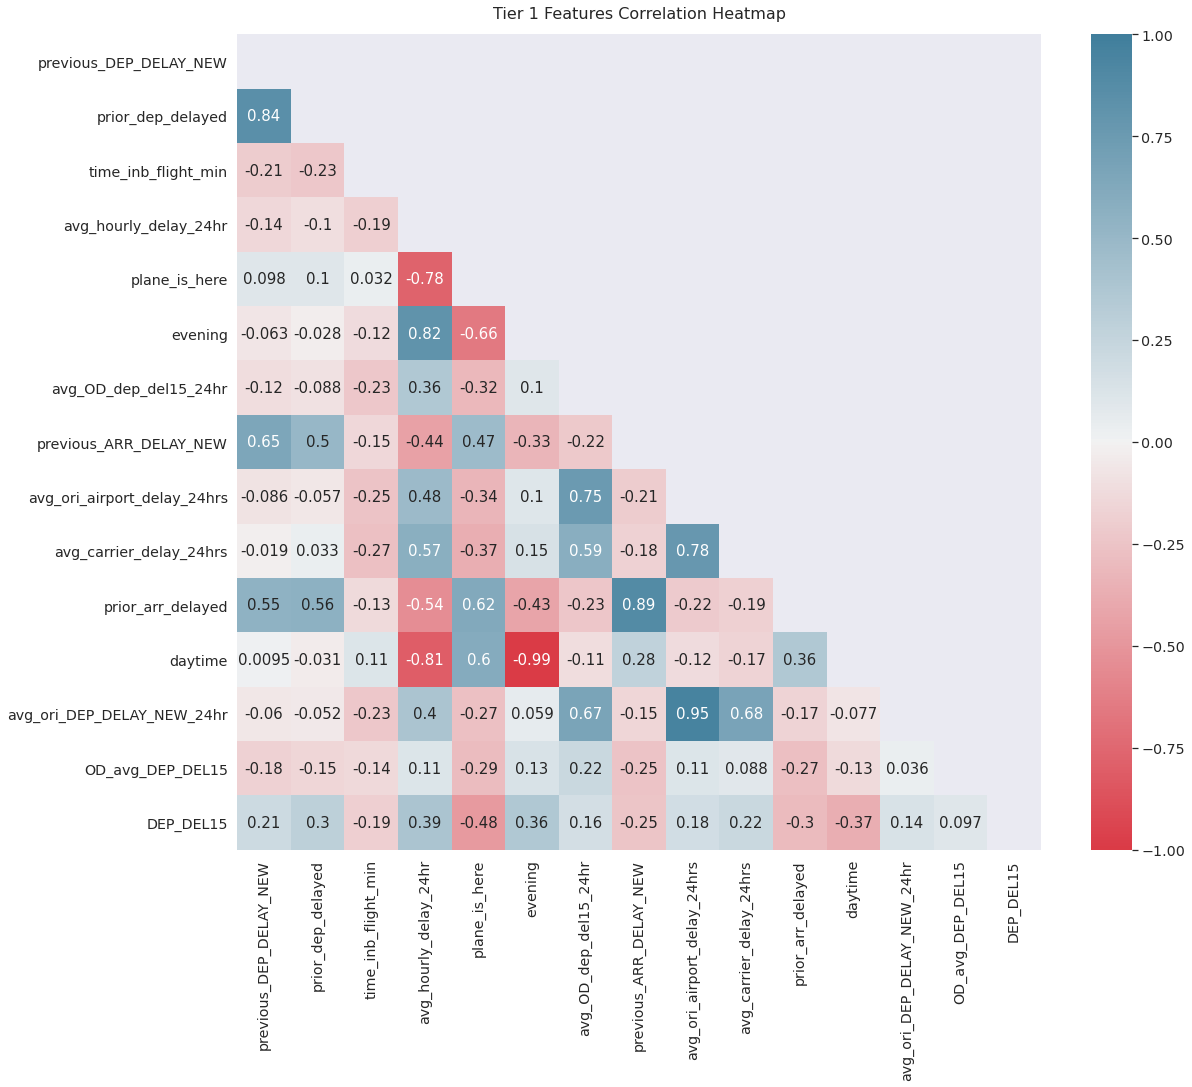

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Tier 1 Features Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


In [0]:
print(feature_list_t2)

['departed_for_current_aiport', 'OD_del_ordinal', 'avg_OD_delay_min_24hr', 'TMP_0_air_temperature_imp', 'WND_3_wind_speed_imp', 'avg_OD_delay_over15_lastQ', 'airline_carrier_del_min', 'airline_carrier_del', 'aw1_mw1_0_thunderstorm', 'OD_del_min_ordinal', 'airline_carrier_del_ordinal', 'VIS_0_visibility_dist_imp', 'depDelayPageRank_ordinal', 'aw1_mw1_0_rain_drizzle', 'DISTANCE', 'origin_avg_DEP_DEL15', 'arrDelayPageRank_ordinal', 'airline_carrier_del_min_ordinal', 'CIG_0_sky_ceiling_height_imp', 'pacific_islands', 'flights_sch_Today_DEST', 'avg_time_inb_flights_carrier_24hr', 'origin_avg_DEP_DELAY_NEW', 'flights_sch_Today_ORIGIN', 'DEW_0_dew_pt_temp_imp', 'aw1_mw1_0_snow']

In [0]:
print(feature_list_t2[:14])
print(feature_list_t2[14:])

['departed_for_current_aiport', 'OD_del_ordinal', 'avg_OD_delay_min_24hr', 'TMP_0_air_temperature_imp', 'WND_3_wind_speed_imp', 'avg_OD_delay_over15_lastQ', 'airline_carrier_del_min', 'airline_carrier_del', 'aw1_mw1_0_thunderstorm', 'OD_del_min_ordinal', 'airline_carrier_del_ordinal', 'VIS_0_visibility_dist_imp', 'depDelayPageRank_ordinal', 'aw1_mw1_0_rain_drizzle']
['DISTANCE', 'origin_avg_DEP_DEL15', 'arrDelayPageRank_ordinal', 'airline_carrier_del_min_ordinal', 'CIG_0_sky_ceiling_height_imp', 'pacific_islands', 'flights_sch_Today_DEST', 'avg_time_inb_flights_carrier_24hr', 'origin_avg_DEP_DELAY_NEW', 'flights_sch_Today_ORIGIN', 'DEW_0_dew_pt_temp_imp', 'aw1_mw1_0_snow']

In [0]:
corr_t2_df = df_5yr_join_corr.select(feature_list_t2[:14] + ['DEP_DEL15'])

col_names = corr_t2_df.columns
features = corr_t2_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df_t2_first_half = corr_df
corr_df_t2_first_half

Out[42]:

departed_for_current_aiport 
 OD_del_ordinal 
 avg_OD_delay_min_24hr 
 TMP_0_air_temperature_imp 
 WND_3_wind_speed_imp 
 avg_OD_delay_over15_lastQ 
 airline_carrier_del_min 
 airline_carrier_del 
 aw1_mw1_0_thunderstorm 
 OD_del_min_ordinal 
 airline_carrier_del_ordinal 
 VIS_0_visibility_dist_imp 
 depDelayPageRank_ordinal 
 aw1_mw1_0_rain_drizzle 
 DEP_DEL15 
 
 
 
 
 departed_for_current_aiport 
 1.000000 
 -0.052218 
 0.004738 
 -0.053268 
 -0.019093 
 0.036299 
 0.046751 
 0.011901 
 0.001480 
 -0.046679 
 0.017430 
 -0.008264 
 -0.238595 
 0.005914 
 -0.067755 
 
 
 OD_del_ordinal 
 -0.052218 
 1.000000 
 -0.105463 
 -0.024755 
 -0.054606 
 -0.555925 
 -0.203453 
 -0.312201 
 -0.004564 
 0.839876 
 0.389748 
 -0.012579 
 0.289519 
 0.002364 
 -0.105119 
 
 
 avg_OD_delay_min_24hr 
 0.004738 
 -0.105463 
 1.000000 
 -0.009827 
 0.029371 
 0.101726 
 0.062459 
 0.043129 
 0.023044 
 -0.111101 
 -0.027949 
 -0.026526 
 -0.010652 
 0.020944 
 0.123566 
 
 
 TMP_0_air_temperature_imp 
 -0.053268 
 -0.024755 
 -0.009827 
 1.000000 
 -0.001813 
 0.051151 
 0.106915 
 0.121839 
 0.062436 
 0.016500 
 -0.025018 
 0.184003 
 -0.045520 
 -0.064205 
 0.040620 
 
 
 WND_3_wind_speed_imp 
 -0.019093 
 -0.054606 
 0.029371 
 -0.001813 
 1.000000 
 0.021943 
 -0.023967 
 -0.032895 
 0.034764 
 -0.051275 
 0.000432 
 0.048975 
 -0.056478 
 0.066193 
 0.080228 
 
 
 avg_OD_delay_over15_lastQ 
 0.036299 
 -0.555925 
 0.101726 
 0.051151 
 0.021943 
 1.000000 
 0.361177 
 0.252354 
 0.010296 
 -0.673557 
 -0.134772 
 0.007714 
 -0.044235 
 0.003561 
 0.065722 
 
 
 airline_carrier_del_min 
 0.046751 
 -0.203453 
 0.062459 
 0.106915 
 -0.023967 
 0.361177 
 1.000000 
 0.791779 
 0.018162 
 -0.265186 
 -0.527547 
 0.014807 
 0.000532 
 -0.009480 
 0.049962 
 
 
 airline_carrier_del 
 0.011901 
 -0.312201 
 0.043129 
 0.121839 
 -0.032895 
 0.252354 
 0.791779 
 1.000000 
 0.017650 
 -0.239566 
 -0.793730 
 0.022208 
 -0.073604 
 -0.015644 
 0.075616 
 
 
 aw1_mw1_0_thunderstorm 
 0.001480 
 -0.004564 
 0.023044 
 0.062436 
 0.034764 
 0.010296 
 0.018162 
 0.017650 
 1.000000 
 -0.003701 
 -0.005169 
 -0.082537 
 -0.004309 
 0.188691 
 0.072502 
 
 
 OD_del_min_ordinal 
 -0.046679 
 0.839876 
 -0.111101 
 0.016500 
 -0.051275 
 -0.673557 
 -0.265186 
 -0.239566 
 -0.003701 
 1.000000 
 0.319320 
 -0.002000 
 0.122518 
 -0.002259 
 -0.081538 
 
 
 airline_carrier_del_ordinal 
 0.017430 
 0.389748 
 -0.027949 
 -0.025018 
 0.000432 
 -0.134772 
 -0.527547 
 -0.793730 
 -0.005169 
 0.319320 
 1.000000 
 -0.018342 
 0.076226 
 0.015849 
 -0.067764 
 
 
 VIS_0_visibility_dist_imp 
 -0.008264 
 -0.012579 
 -0.026526 
 0.184003 
 0.048975 
 0.007714 
 0.014807 
 0.022208 
 -0.082537 
 -0.002000 
 -0.018342 
 1.000000 
 -0.009835 
 -0.406420 
 -0.049847 
 
 
 depDelayPageRank_ordinal 
 -0.238595 
 0.289519 
 -0.010652 
 -0.045520 
 -0.056478 
 -0.044235 
 0.000532 
 -0.073604 
 -0.004309 
 0.122518 
 0.076226 
 -0.009835 
 1.000000 
 -0.005848 
 -0.041149 
 
 
 aw1_mw1_0_rain_drizzle 
 0.005914 
 0.002364 
 0.020944 
 -0.064205 
 0.066193 
 0.003561 
 -0.009480 
 -0.015644 
 0.188691 
 -0.002259 
 0.015849 
 -0.406420 
 -0.005848 
 1.000000 
 0.058414 
 
 
 DEP_DEL15 
 -0.067755 
 -0.105119 
 0.123566 
 0.040620 
 0.080228 
 0.065722 
 0.049962 
 0.075616 
 0.072502 
 -0.081538 
 -0.067764 
 -0.049847 
 -0.041149 
 0.058414 
 1.000000

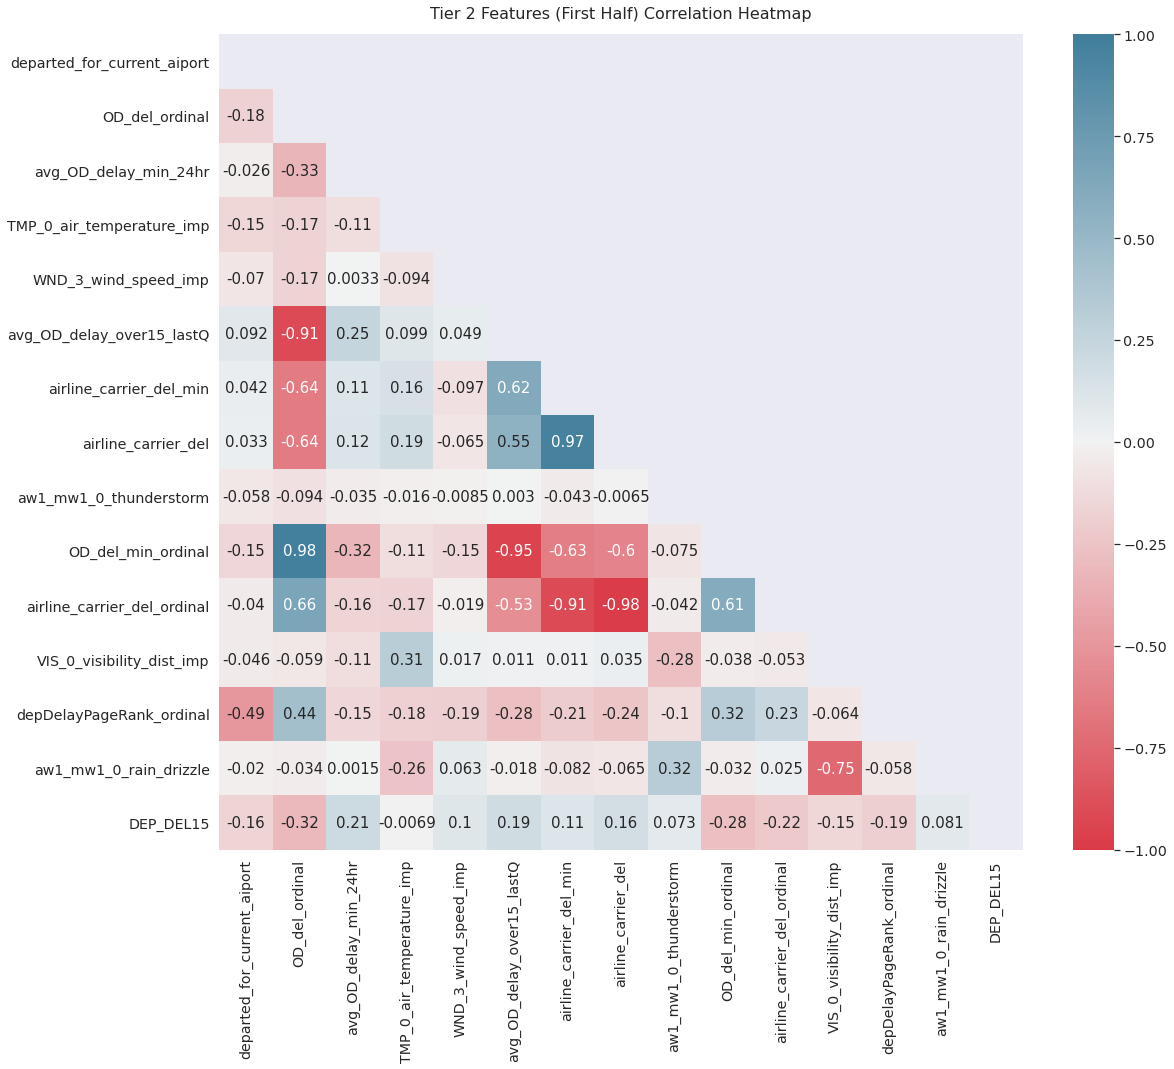

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df_t2_first_half)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df_t2_first_half.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Tier 2 Features (First Half) Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')


In [0]:
print(feature_list_t2[14:])

['DISTANCE', 'origin_avg_DEP_DEL15', 'arrDelayPageRank_ordinal', 'airline_carrier_del_min_ordinal', 'CIG_0_sky_ceiling_height_imp', 'pacific_islands', 'flights_sch_Today_DEST', 'avg_time_inb_flights_carrier_24hr', 'origin_avg_DEP_DELAY_NEW', 'flights_sch_Today_ORIGIN', 'DEW_0_dew_pt_temp_imp', 'aw1_mw1_0_snow']

In [0]:
corr_t2_df = df_5yr_join_corr.select(feature_list_t2[14:] + ['DEP_DEL15'])

col_names = corr_t2_df.columns
features = corr_t2_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df_t2_second_half = corr_df
corr_df_t2_second_half

Out[45]:

DISTANCE 
 origin_avg_DEP_DEL15 
 arrDelayPageRank_ordinal 
 airline_carrier_del_min_ordinal 
 CIG_0_sky_ceiling_height_imp 
 pacific_islands 
 flights_sch_Today_DEST 
 avg_time_inb_flights_carrier_24hr 
 origin_avg_DEP_DELAY_NEW 
 flights_sch_Today_ORIGIN 
 DEW_0_dew_pt_temp_imp 
 aw1_mw1_0_snow 
 DEP_DEL15 
 
 
 
 
 DISTANCE 
 1.000000 
 0.083518 
 -0.209656 
 -0.003516 
 0.002001 
 0.072109 
 0.054662 
 0.050236 
 0.008985 
 0.060742 
 0.019079 
 -0.011849 
 0.019138 
 
 
 origin_avg_DEP_DEL15 
 0.083518 
 1.000000 
 -0.365507 
 -0.134055 
 0.015697 
 -0.280940 
 -0.081052 
 -0.003574 
 0.815368 
 0.276067 
 0.124404 
 -0.034136 
 0.071348 
 
 
 arrDelayPageRank_ordinal 
 -0.209656 
 -0.365507 
 1.000000 
 -0.002066 
 0.047272 
 0.142470 
 0.319773 
 -0.031039 
 -0.074371 
 -0.602079 
 0.016613 
 0.012948 
 -0.038866 
 
 
 airline_carrier_del_min_ordinal 
 -0.003516 
 -0.134055 
 -0.002066 
 1.000000 
 0.000102 
 0.149517 
 0.053058 
 -0.017228 
 -0.157393 
 0.050531 
 0.036006 
 -0.008648 
 -0.041860 
 
 
 CIG_0_sky_ceiling_height_imp 
 0.002001 
 0.015697 
 0.047272 
 0.000102 
 1.000000 
 0.045667 
 0.014843 
 -0.004887 
 0.013160 
 -0.010002 
 -0.048182 
 -0.123676 
 -0.054055 
 
 
 pacific_islands 
 0.072109 
 -0.280940 
 0.142470 
 0.149517 
 0.045667 
 1.000000 
 -0.059693 
 -0.010820 
 -0.238752 
 -0.120293 
 0.135794 
 -0.014204 
 -0.031242 
 
 
 flights_sch_Today_DEST 
 0.054662 
 -0.081052 
 0.319773 
 0.053058 
 0.014843 
 -0.059693 
 1.000000 
 0.030841 
 0.055266 
 -0.299191 
 0.036693 
 -0.000865 
 -0.013707 
 
 
 avg_time_inb_flights_carrier_24hr 
 0.050236 
 -0.003574 
 -0.031039 
 -0.017228 
 -0.004887 
 -0.010820 
 0.030841 
 1.000000 
 0.000953 
 0.031326 
 -0.033712 
 0.003263 
 -0.001936 
 
 
 origin_avg_DEP_DELAY_NEW 
 0.008985 
 0.815368 
 -0.074371 
 -0.157393 
 0.013160 
 -0.238752 
 0.055266 
 0.000953 
 1.000000 
 0.094336 
 0.131502 
 -0.019323 
 0.047784 
 
 
 flights_sch_Today_ORIGIN 
 0.060742 
 0.276067 
 -0.602079 
 0.050531 
 -0.010002 
 -0.120293 
 -0.299191 
 0.031326 
 0.094336 
 1.000000 
 -0.000892 
 -0.024634 
 0.030749 
 
 
 DEW_0_dew_pt_temp_imp 
 0.019079 
 0.124404 
 0.016613 
 0.036006 
 -0.048182 
 0.135794 
 0.036693 
 -0.033712 
 0.131502 
 -0.000892 
 1.000000 
 -0.157062 
 0.024846 
 
 
 aw1_mw1_0_snow 
 -0.011849 
 -0.034136 
 0.012948 
 -0.008648 
 -0.123676 
 -0.014204 
 -0.000865 
 0.003263 
 -0.019323 
 -0.024634 
 -0.157062 
 1.000000 
 0.042123 
 
 
 DEP_DEL15 
 0.019138 
 0.071348 
 -0.038866 
 -0.041860 
 -0.054055 
 -0.031242 
 -0.013707 
 -0.001936 
 0.047784 
 0.030749 
 0.024846 
 0.042123 
 1.000000

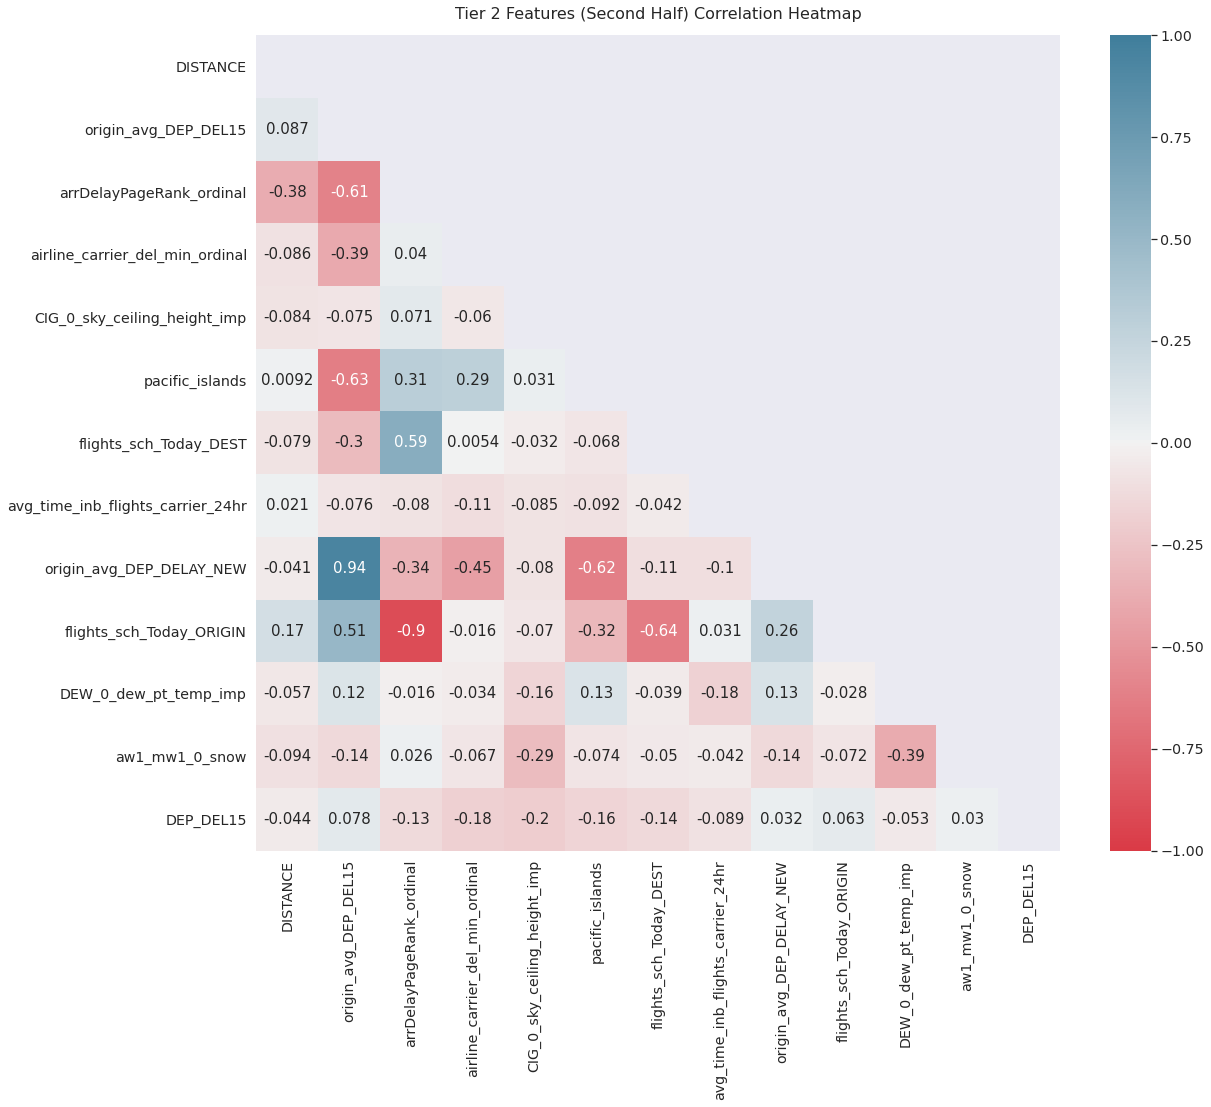

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df_t2_second_half)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df_t2_second_half.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Tier 2 Features (Second Half) Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr2-2.png",bbox_inches='tight')


In [0]:
# untiered features
feature_list_t1t2 = feature_list_t1 + feature_list_t2
feature_list_untiered = [feat for feat in feature_list_full if feat not in feature_list_t1t2]
print(feature_list_untiered)
print(len(feature_list_untiered))

['ORI_elevation', 'DEST_elevation', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'spring', 'winter', 'autumn', 'weekend_or_holiday', 'depDelayPageRank', 'arrDelayPageRank', 'OC1_0_wind_gust_spd_rate_imp', 'AA1_1_liquid_precip', 'AA3_1_liquid_precip', 'gd1_0_sky_coverage', 'au2_4_extreme_wind_weather', 'mv1_0_sand_dust_near', 'mv1_0_thunder_rain_near', 'aw1_mw1_0_smoke_haze_dust', 'aw1_mw1_0_fog', 'aw1_mw1_0_freezing_rain_drizzle', 'aw1_mw1_0_hail_or_ice', 'aw1_mw1_0_tornado', 'SLP_0_avg_station_press_imp', 'MA1_0_altimeter_set_rate_imp', 'MA1_2_station_pres_rate_imp', 'GD1_3_cloud_height_imp', 'avg_OD_num_flights_24hr', 'avg_time_inb_flights_origin_24hr', 'avg_time_inb_flights_dest_24hr', 'avg_carrier_delay_over15_lastQ', 'avg_origin_delay_over15_lastQ', 'origin_del_ordinal', 'origin_del_min_ordinal', 'OD_avg_DEP_DELAY_NEW']
38

In [0]:
print(feature_list_untiered[:19])
print(feature_list_untiered[19:])

['ORI_elevation', 'DEST_elevation', 'new_england', 'mid_atlantic', 'south', 'midwest', 'southwest', 'west', 'spring', 'winter', 'autumn', 'weekend_or_holiday', 'depDelayPageRank', 'arrDelayPageRank', 'OC1_0_wind_gust_spd_rate_imp', 'AA1_1_liquid_precip', 'AA3_1_liquid_precip', 'gd1_0_sky_coverage', 'au2_4_extreme_wind_weather']
['mv1_0_sand_dust_near', 'mv1_0_thunder_rain_near', 'aw1_mw1_0_smoke_haze_dust', 'aw1_mw1_0_fog', 'aw1_mw1_0_freezing_rain_drizzle', 'aw1_mw1_0_hail_or_ice', 'aw1_mw1_0_tornado', 'SLP_0_avg_station_press_imp', 'MA1_0_altimeter_set_rate_imp', 'MA1_2_station_pres_rate_imp', 'GD1_3_cloud_height_imp', 'avg_OD_num_flights_24hr', 'avg_time_inb_flights_origin_24hr', 'avg_time_inb_flights_dest_24hr', 'avg_carrier_delay_over15_lastQ', 'avg_origin_delay_over15_lastQ', 'origin_del_ordinal', 'origin_del_min_ordinal', 'OD_avg_DEP_DELAY_NEW']

In [0]:
corr_untiered_df = df_5yr_join_corr.select(feature_list_untiered[:19] + ['DEP_DEL15'])

col_names = corr_untiered_df.columns
features = corr_untiered_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df_untiered_first_half = corr_df
corr_df_untiered_first_half

Out[50]:

ORI_elevation 
 DEST_elevation 
 new_england 
 mid_atlantic 
 south 
 midwest 
 southwest 
 west 
 spring 
 winter 
 autumn 
 weekend_or_holiday 
 depDelayPageRank 
 arrDelayPageRank 
 OC1_0_wind_gust_spd_rate_imp 
 AA1_1_liquid_precip 
 AA3_1_liquid_precip 
 gd1_0_sky_coverage 
 au2_4_extreme_wind_weather 
 DEP_DEL15 
 
 
 
 
 ORI_elevation 
 1.000000 
 0.174347 
 -0.105296 
 -0.176817 
 -0.170508 
 -0.020515 
 0.007785 
 0.377454 
 -0.005255 
 0.000377 
 -0.000182 
 0.001657 
 0.186880 
 0.167391 
 -0.004773 
 -0.020796 
 -0.004912 
 -0.055748 
 0.002950 
 -0.009462 
 
 
 DEST_elevation 
 0.174347 
 1.000000 
 -0.051515 
 -0.066202 
 -0.105924 
 0.014063 
 0.057186 
 0.137728 
 -0.005258 
 0.000709 
 -0.000673 
 0.001954 
 -0.007094 
 -0.005780 
 -0.005856 
 -0.008230 
 0.000558 
 -0.008977 
 0.000247 
 -0.017166 
 
 
 new_england 
 -0.105296 
 -0.051515 
 1.000000 
 -0.062006 
 -0.112778 
 -0.077933 
 -0.074275 
 -0.105291 
 -0.000878 
 -0.005696 
 0.003157 
 -0.002998 
 -0.101320 
 -0.086153 
 0.020586 
 0.002904 
 -0.002389 
 0.011646 
 -0.000375 
 0.002543 
 
 
 mid_atlantic 
 -0.176817 
 -0.066202 
 -0.062006 
 1.000000 
 -0.217435 
 -0.150254 
 -0.143203 
 -0.203000 
 0.001415 
 -0.001401 
 0.001982 
 -0.003917 
 -0.093122 
 -0.072311 
 0.046901 
 0.009870 
 -0.001926 
 0.027358 
 0.000286 
 0.018352 
 
 
 south 
 -0.170508 
 -0.105924 
 -0.112778 
 -0.217435 
 1.000000 
 -0.273284 
 -0.260459 
 -0.369220 
 0.008522 
 0.006638 
 -0.005081 
 0.003106 
 -0.038875 
 -0.080835 
 -0.033752 
 0.032423 
 0.001896 
 -0.014564 
 -0.000467 
 -0.003454 
 
 
 midwest 
 -0.020515 
 0.014063 
 -0.077933 
 -0.150254 
 -0.273284 
 1.000000 
 -0.179985 
 -0.255142 
 -0.000162 
 -0.009444 
 0.004121 
 -0.006718 
 0.161868 
 0.185088 
 0.057143 
 -0.000279 
 0.002681 
 0.098595 
 -0.001052 
 -0.003602 
 
 
 southwest 
 0.007785 
 0.057186 
 -0.074275 
 -0.143203 
 -0.260459 
 -0.179985 
 1.000000 
 -0.243168 
 0.000746 
 0.005983 
 -0.001283 
 0.001186 
 0.120038 
 0.107195 
 0.004125 
 -0.003800 
 0.002832 
 -0.011929 
 0.000860 
 0.007081 
 
 
 west 
 0.377454 
 0.137728 
 -0.105291 
 -0.203000 
 -0.369220 
 -0.255142 
 -0.243168 
 1.000000 
 -0.009490 
 -0.001188 
 0.000954 
 0.002940 
 -0.046892 
 -0.033087 
 -0.070831 
 -0.036106 
 -0.003234 
 -0.067881 
 0.000698 
 -0.003903 
 
 
 spring 
 -0.005255 
 -0.005258 
 -0.000878 
 0.001415 
 0.008522 
 -0.000162 
 0.000746 
 -0.009490 
 1.000000 
 -0.321840 
 -0.334994 
 0.091881 
 -0.001884 
 -0.001470 
 0.072560 
 -0.004410 
 0.002518 
 0.025903 
 0.000232 
 -0.006419 
 
 
 winter 
 0.000377 
 0.000709 
 -0.005696 
 -0.001401 
 0.006638 
 -0.009444 
 0.005983 
 -0.001188 
 -0.321840 
 1.000000 
 -0.317157 
 -0.008468 
 0.001829 
 0.005602 
 0.011536 
 -0.005062 
 0.000896 
 0.101051 
 -0.000698 
 0.011818 
 
 
 autumn 
 -0.000182 
 -0.000673 
 0.003157 
 0.001982 
 -0.005081 
 0.004121 
 -0.001283 
 0.000954 
 -0.334994 
 -0.317157 
 1.000000 
 -0.030741 
 0.001521 
 0.000464 
 -0.026648 
 -0.004779 
 -0.000211 
 -0.012718 
 -0.000640 
 -0.058557 
 
 
 weekend_or_holiday 
 0.001657 
 0.001954 
 -0.002998 
 -0.003917 
 0.003106 
 -0.006718 
 0.001186 
 0.002940 
 0.091881 
 -0.008468 
 -0.030741 
 1.000000 
 -0.002877 
 -0.002527 
 0.005767 
 0.000875 
 0.000265 
 0.006843 
 0.001966 
 -0.002619 
 
 
 depDelayPageRank 
 0.186880 
 -0.007094 
 -0.101320 
 -0.093122 
 -0.038875 
 0.161868 
 0.120038 
 -0.046892 
 -0.001884 
 0.001829 
 0.001521 
 -0.002877 
 1.000000 
 0.986481 
 0.012583 
 0.011139 
 -0.000946 
 -0.012289 
 0.002327 
 0.035133 
 
 
 arrDelayPageRank 
 0.167391 
 -0.005780 
 -0.086153 
 -0.072311 
 -0.080835 
 0.185088 
 0.107195 
 -0.033087 
 -0.001470 
 0.005602 
 0.000464 
 -0.002527 
 0.986481 
 1.000000 
 0.015849 
 0.009528 
 -0.001689 
 -0.011865 
 0.002204 
 0.034418 
 
 
 OC1_0_wind_gust_spd_rate_imp 
 -0.004773 
 -0.005856 
 0.020586 
 0.046901 
 -0.033752 
 0.057143 
 0.004125 
 -0.070831 
 0.072560 
 0.011536 
 -0.026648 
 0.005767 
 0.012583 
 0.015849 
 1.00

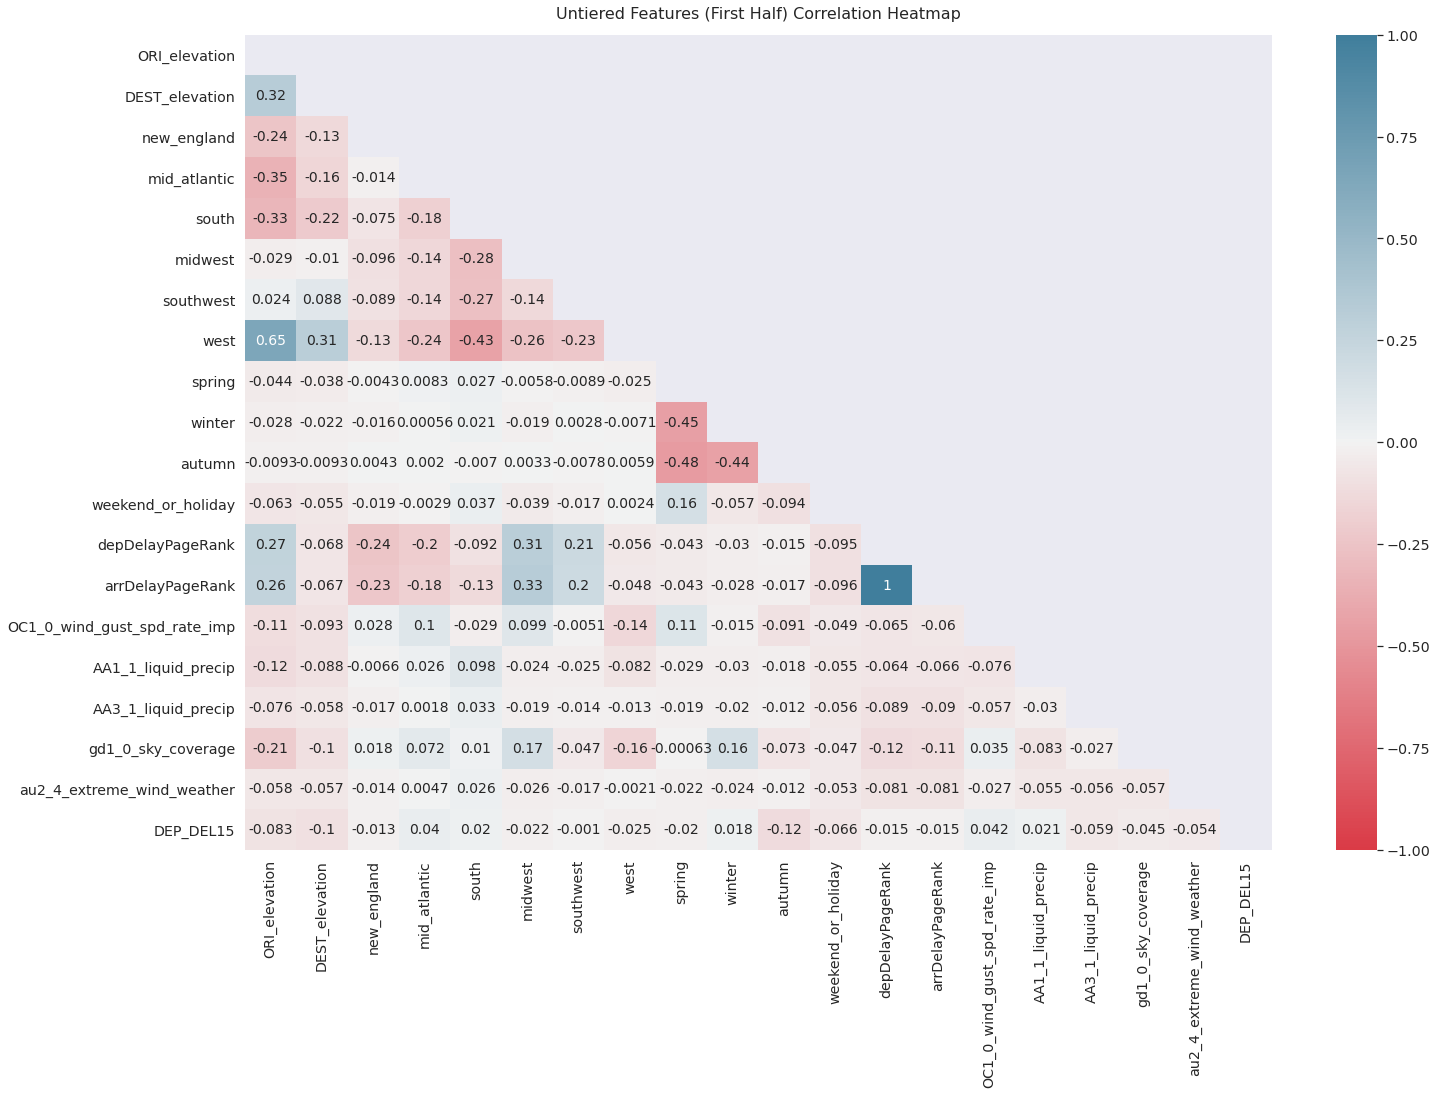

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(23, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df_untiered_first_half)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df_untiered_first_half.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":14}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Untiered Features (First Half) Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr3-1.png",bbox_inches='tight')


In [0]:
print(feature_list_untiered[19:])

['mv1_0_sand_dust_near', 'mv1_0_thunder_rain_near', 'aw1_mw1_0_smoke_haze_dust', 'aw1_mw1_0_fog', 'aw1_mw1_0_freezing_rain_drizzle', 'aw1_mw1_0_hail_or_ice', 'aw1_mw1_0_tornado', 'SLP_0_avg_station_press_imp', 'MA1_0_altimeter_set_rate_imp', 'MA1_2_station_pres_rate_imp', 'GD1_3_cloud_height_imp', 'avg_OD_num_flights_24hr', 'avg_time_inb_flights_origin_24hr', 'avg_time_inb_flights_dest_24hr', 'avg_carrier_delay_over15_lastQ', 'avg_origin_delay_over15_lastQ', 'origin_del_ordinal', 'origin_del_min_ordinal', 'OD_avg_DEP_DELAY_NEW']

In [0]:
corr_untiered_df = df_5yr_join_corr.select(feature_list_untiered[19:] + ['DEP_DEL15'])

col_names = corr_untiered_df.columns
features = corr_untiered_df.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df_untiered_second_half = corr_df
corr_df_untiered_second_half

Out[56]:

mv1_0_sand_dust_near 
 mv1_0_thunder_rain_near 
 aw1_mw1_0_smoke_haze_dust 
 aw1_mw1_0_fog 
 aw1_mw1_0_freezing_rain_drizzle 
 aw1_mw1_0_hail_or_ice 
 aw1_mw1_0_tornado 
 SLP_0_avg_station_press_imp 
 MA1_0_altimeter_set_rate_imp 
 MA1_2_station_pres_rate_imp 
 GD1_3_cloud_height_imp 
 avg_OD_num_flights_24hr 
 avg_time_inb_flights_origin_24hr 
 avg_time_inb_flights_dest_24hr 
 avg_carrier_delay_over15_lastQ 
 avg_origin_delay_over15_lastQ 
 origin_del_ordinal 
 origin_del_min_ordinal 
 OD_avg_DEP_DELAY_NEW 
 DEP_DEL15 
 
 
 
 
 mv1_0_sand_dust_near 
 1.000000 
 -0.000319 
 0.001662 
 -0.002379 
 -0.000228 
 -0.000160 
 -0.000012 
 -0.014002 
 -0.013136 
 -0.010713 
 0.007548 
 0.002053 
 -0.001049 
 -0.000414 
 -0.001582 
 -0.003898 
 -0.004589 
 -0.000799 
 -0.000740 
 0.002785 
 
 
 mv1_0_thunder_rain_near 
 -0.000319 
 1.000000 
 -0.001540 
 0.011119 
 -0.000789 
 -0.000178 
 0.000643 
 -0.008776 
 -0.013172 
 -0.009834 
 -0.016296 
 -0.009330 
 -0.001254 
 -0.001045 
 0.006718 
 0.007705 
 0.005243 
 -0.000580 
 0.006927 
 0.018225 
 
 
 aw1_mw1_0_smoke_haze_dust 
 0.001662 
 -0.001540 
 1.000000 
 -0.019481 
 -0.002154 
 -0.001391 
 0.000154 
 -0.000790 
 -0.001800 
 0.002358 
 -0.029373 
 0.009285 
 0.000539 
 0.004030 
 -0.007377 
 -0.015976 
 0.017899 
 0.020212 
 -0.007446 
 0.002827 
 
 
 aw1_mw1_0_fog 
 -0.002379 
 0.011119 
 -0.019481 
 1.000000 
 0.066542 
 0.028585 
 0.000145 
 -0.007997 
 -0.061916 
 0.014333 
 -0.201796 
 -0.015787 
 0.002454 
 0.005336 
 -0.002697 
 0.000039 
 0.006288 
 -0.005742 
 -0.002052 
 0.034330 
 
 
 aw1_mw1_0_freezing_rain_drizzle 
 -0.000228 
 -0.000789 
 -0.002154 
 0.066542 
 1.000000 
 0.136584 
 -0.000033 
 0.008595 
 0.003086 
 -0.003667 
 -0.021818 
 -0.006183 
 0.000096 
 0.001119 
 -0.004180 
 -0.004660 
 0.003675 
 0.001889 
 -0.003046 
 0.015413 
 
 
 aw1_mw1_0_hail_or_ice 
 -0.000160 
 -0.000178 
 -0.001391 
 0.028585 
 0.136584 
 1.000000 
 0.001356 
 0.005530 
 0.001810 
 0.003837 
 -0.011874 
 -0.002074 
 -0.000077 
 0.000525 
 -0.001341 
 -0.000142 
 0.000130 
 -0.000868 
 -0.000236 
 0.012177 
 
 
 aw1_mw1_0_tornado 
 -0.000012 
 0.000643 
 0.000154 
 0.000145 
 -0.000033 
 0.001356 
 1.000000 
 -0.000245 
 -0.000477 
 0.000477 
 -0.000810 
 -0.000172 
 -0.000073 
 -0.000048 
 -0.000049 
 0.000252 
 -0.000425 
 -0.000511 
 -0.000121 
 -0.000135 
 
 
 SLP_0_avg_station_press_imp 
 -0.014002 
 -0.008776 
 -0.000790 
 -0.007997 
 0.008595 
 0.005530 
 -0.000245 
 1.000000 
 0.838126 
 0.236385 
 0.068937 
 -0.031956 
 0.033822 
 0.043654 
 -0.022080 
 0.006210 
 0.009505 
 -0.033001 
 -0.004223 
 -0.041776 
 
 
 MA1_0_altimeter_set_rate_imp 
 -0.013136 
 -0.013172 
 -0.001800 
 -0.061916 
 0.003086 
 0.001810 
 -0.000477 
 0.838126 
 1.000000 
 0.099791 
 0.131959 
 -0.028451 
 0.026409 
 0.035724 
 -0.016128 
 -0.004920 
 -0.002101 
 -0.027928 
 -0.004834 
 -0.047718 
 
 
 MA1_2_station_pres_rate_imp 
 -0.010713 
 -0.009834 
 0.002358 
 0.014333 
 -0.003667 
 0.003837 
 0.000477 
 0.236385 
 0.099791 
 1.000000 
 -0.122953 
 0.051926 
 0.025185 
 0.016391 
 0.012026 
 0.129437 
 -0.075018 
 -0.092663 
 0.040955 
 0.002178 
 
 
 GD1_3_cloud_height_imp 
 0.007548 
 -0.016296 
 -0.029373 
 -0.201796 
 -0.021818 
 -0.011874 
 -0.000810 
 0.068937 
 0.131959 
 -0.122953 
 1.000000 
 0.009629 
 -0.002276 
 -0.002209 
 -0.015921 
 -0.051604 
 -0.056493 
 0.013553 
 -0.018195 
 -0.052230 
 
 
 avg_OD_num_flights_24hr 
 0.002053 
 -0.009330 
 0.009285 
 -0.015787 
 -0.006183 
 -0.002074 
 -0.000172 
 -0.031956 
 -0.028451 
 0.051926 
 0.009629 
 1.000000 
 0.007391 
 0.030660 
 -0.020250 
 0.027350 
 -0.151598 
 -0.054071 
 0.036976 
 0.016414 
 
 
 avg_time_inb_flights_origin_24hr 
 -0.001049 
 -0.001254 
 0.000539 
 0.002454 
 0.000096 
 -0.000077 
 -0.000073 
 0.033822 
 0.026409 
 0.025185 
 -0.002276 
 0.007391 
 1.000000 
 0.189366 
 0.003726 
 0.014741 
 -0.014806 
 -0.025812 
 0.007691 
 0.004253 
 
 
 avg_time_inb_flights_dest_24hr 
 -0.000414 
 -0.001045 
 0.004030 


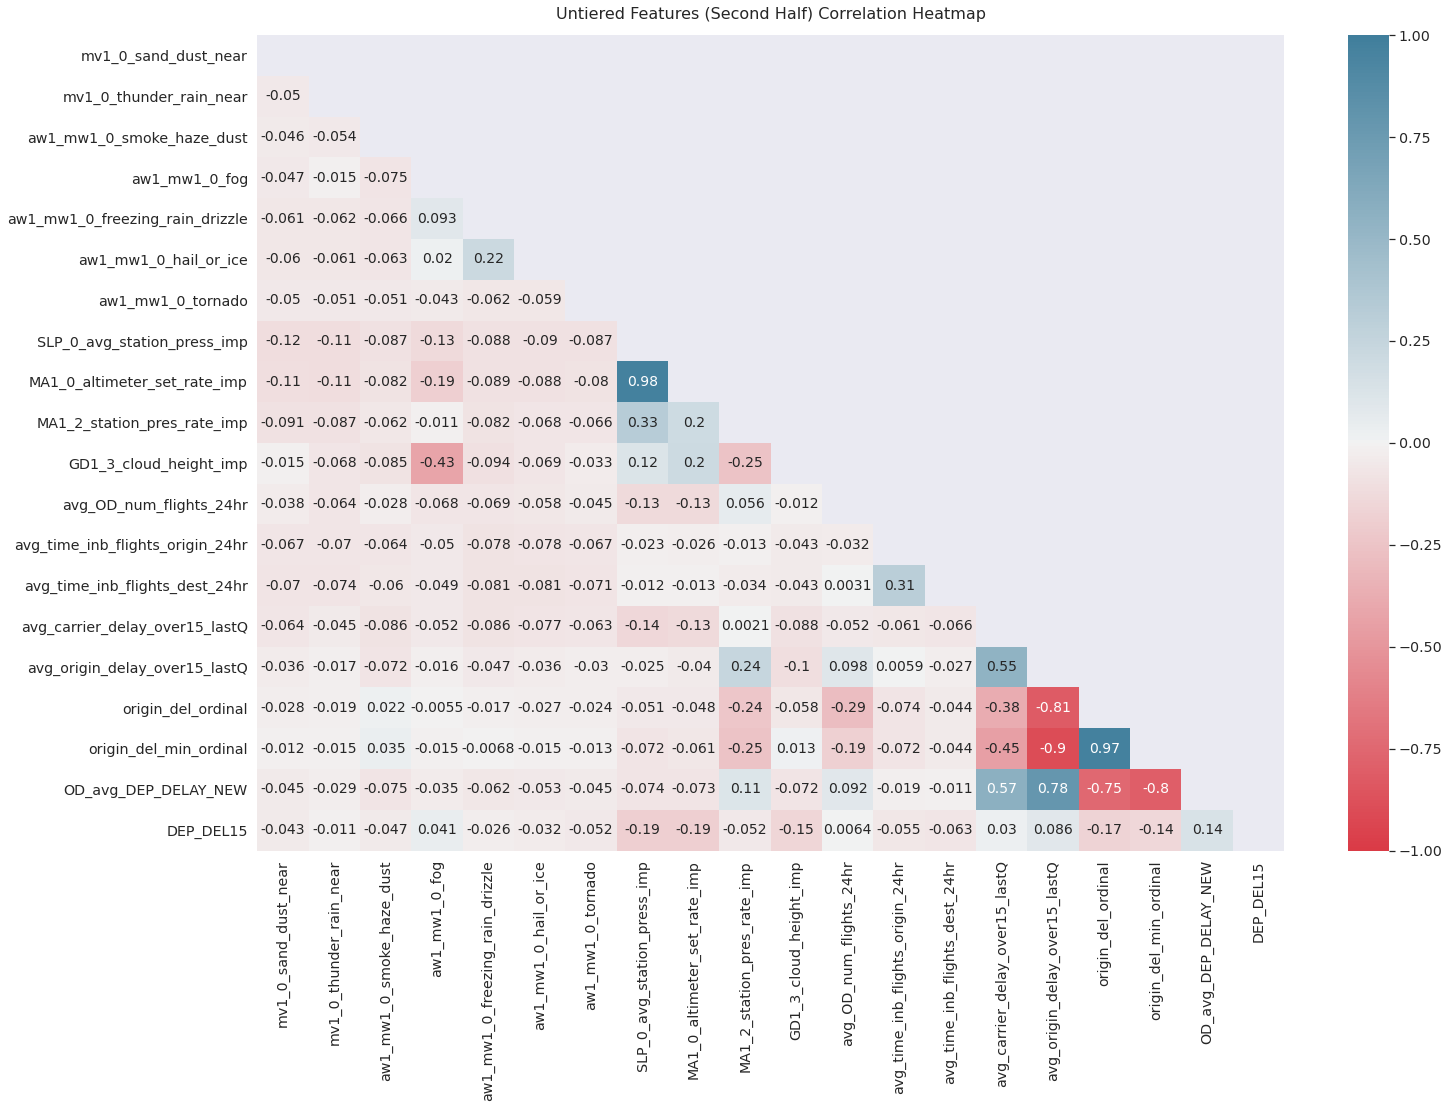

In [0]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(23, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df_untiered_second_half)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df_untiered_second_half.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":14}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Untiered Features (Second Half) Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr3-2.png",bbox_inches='tight')
